# Gaussian Processes

In [ ]:
%pip install pymc pytensor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc as pm

## Covariance Functions and Kernel

In [ ]:
def exp_quad_kernel(x,knots,l=1):
  return np.array([np.exp(-(x-k)**2/(2*l**2)) for k in knots])

In [ ]:
data = np.array([-1,0,1,2])
#data = np.array([-1,0])
cov = exp_quad_kernel(data,data,1)



In [ ]:
print(cov)

[[1.         0.60653066 0.13533528 0.011109  ]
 [0.60653066 1.         0.60653066 0.13533528]
 [0.13533528 0.60653066 1.         0.60653066]
 [0.011109   0.13533528 0.60653066 1.        ]]


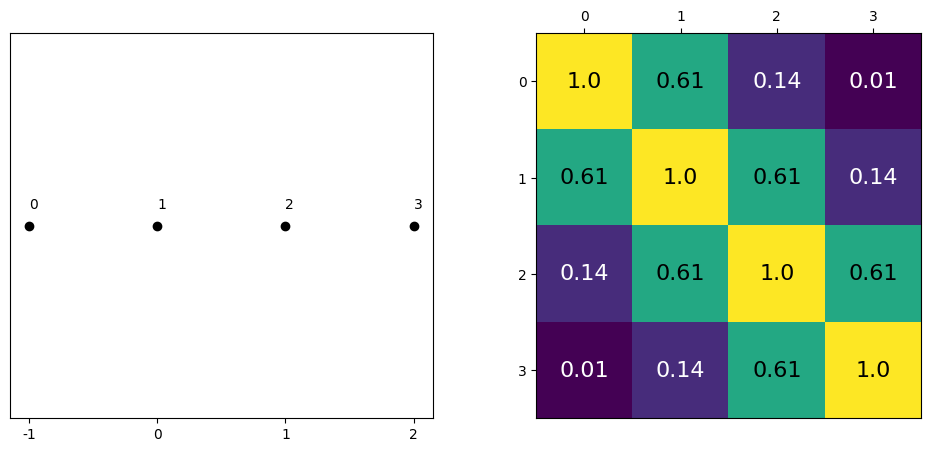

In [ ]:
_, ax=plt.subplots(1,2,figsize=(12,5))

ax[0].plot(data, np.zeros_like(data),'ko')
ax[0].set_yticks([])

for idx,i in enumerate(data):
  ax[0].text(i,0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data,2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors=['w','k']

for i in range(len(cov)):
  for j in range(len(cov)):
    ax[1].text(i,j, round(cov[i,j],2), color=colors[int(im.norm(cov[i,j])>0.5)], ha = 'center', va='center', fontdict={'size':16})

ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Text(-0.03, 0.5, 'f(x)')

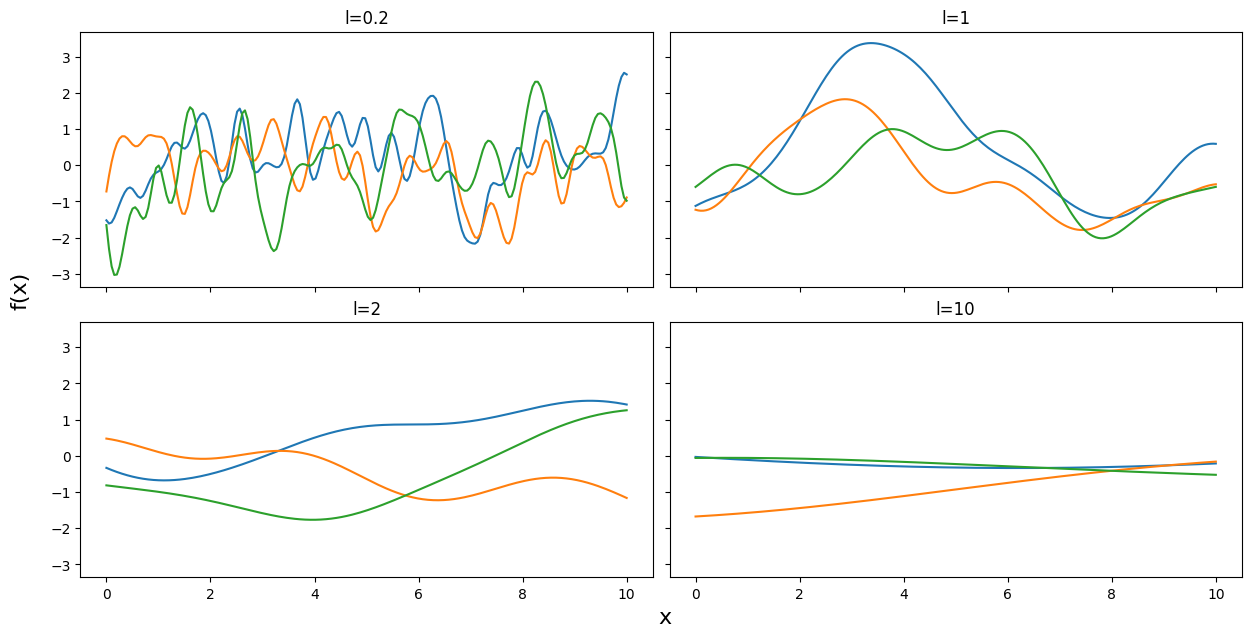

In [ ]:

np.random.seed(24)
test_points = np.linspace(0,10,200)
fig, ax = plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True,constrained_layout=True)
ax = np.ravel(ax)
for idx, l in enumerate((0.2,1,2,10)):
  cov = exp_quad_kernel(test_points, test_points, l)
  ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov,size=3).T)
  ax[idx].set_title(f'l={l}')

fig.text(0.51,-0.03,'x', fontsize=16)
fig.text(-0.03,0.5,'f(x)', fontsize=16, rotation=90)




# Gaussian Processes


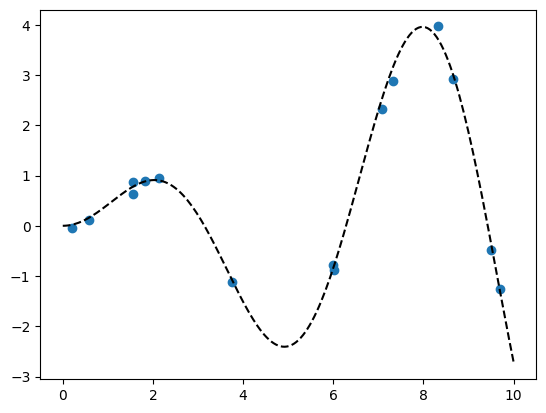

In [ ]:
np.random.seed(42)

x = np.random.uniform(0,10,size=15)

scale = 0.50
y = np.random.normal(scale*x*np.sin(x), 0.1)

plt.plot(x,y,'o')

true_x = np.linspace(0,10,200)
true_y = scale*true_x*np.sin(true_x)
plt.plot(true_x,true_y, 'k--')


In [ ]:
X = x[:,None]

with pm.Model() as model_reg:
  #hyperprior for lengthscale kernel parameter
  l = pm.Gamma('l',2,0.5)
  #instantiate a covariance function
  cov = pm.gp.cov.ExpQuad(1,ls=l)
  #mean = pm.gp.mean.Constant(c=0)
  #instantiate a GP prior
  gp = pm.gp.Marginal(cov_func=cov)#mean_func=mean,
  #prior
  eps = pm.HalfNormal('eps',25)
  #likelihood
  y_pred = gp.marginal_likelihood('y_pred',X=X, y=y, noise=eps)
  trace_reg = pm.sample(2000, return_inferencedata=True, target_accept=0.95)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

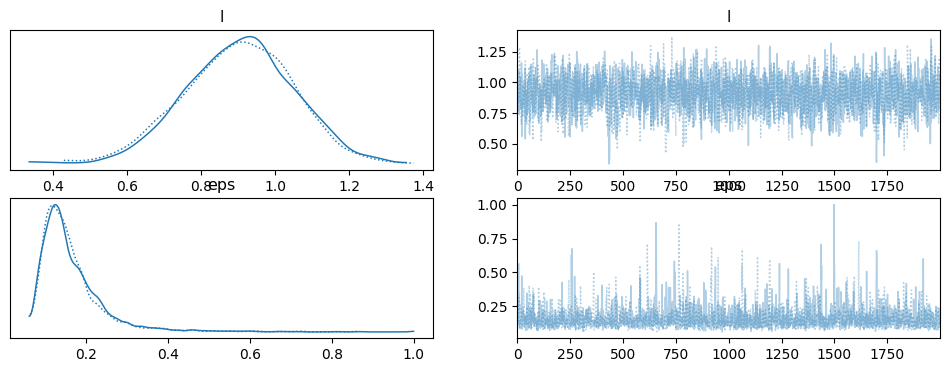

In [ ]:
import arviz as az
az.plot_trace(trace_reg)

In [ ]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [ ]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, var_names=['f_pred'])

In [ ]:
pred_samples

Inference data with groups:
	> posterior_predictive
	> observed_data

In [ ]:
print(np.shape(pred_samples.posterior_predictive['f_pred'].mean(axis=0).T))
print(np.shape(X_new))

(100, 2000)
(100, 1)


Text(0.5, 0, 'X')

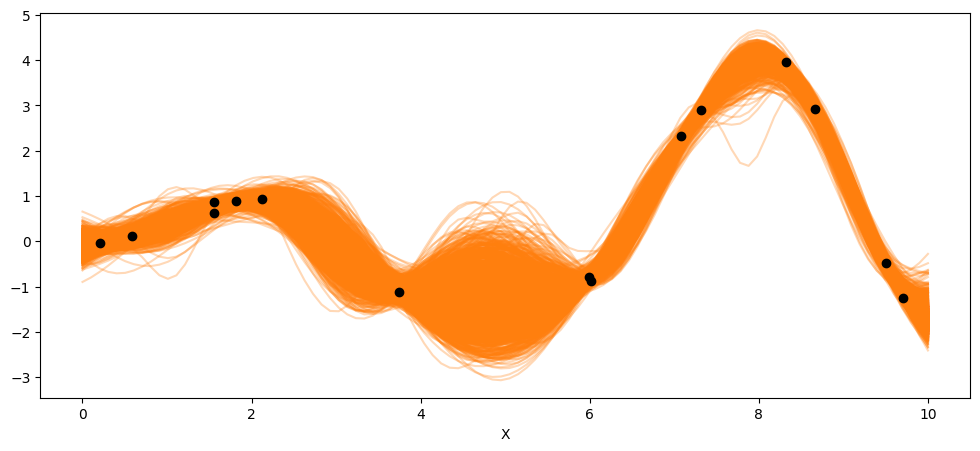

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples.posterior_predictive['f_pred'].mean(axis=0).T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Text(0, 0.5, 'f(x)')

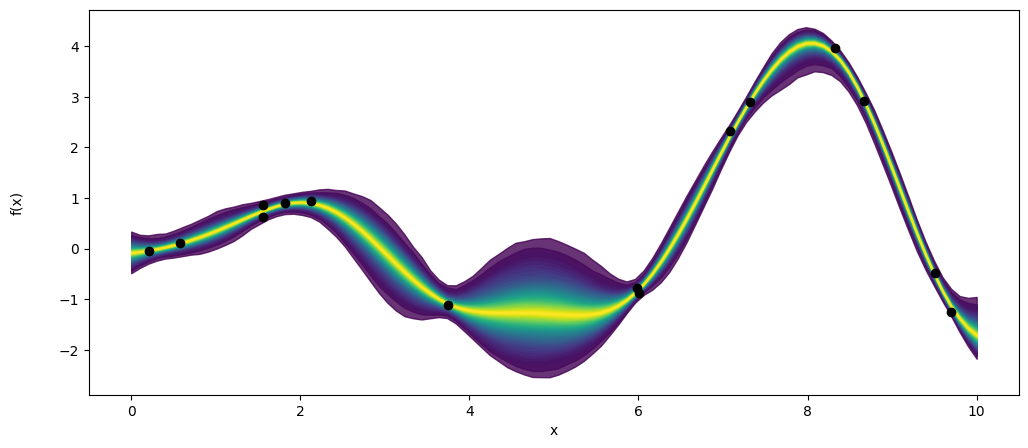

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
pm.gp.util.plot_gp_dist(ax, pred_samples.posterior_predictive['f_pred'].mean(axis=0), X_new, palette='viridis',plot_samples=False)

ax.plot(X,y,'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)',labelpad=25)

Text(0.5, 0, 'X')

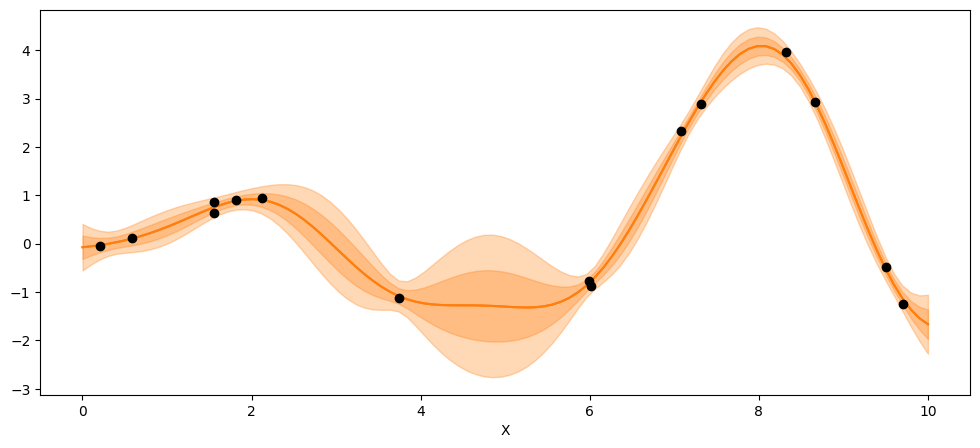

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
point = {'l':trace_reg.posterior['l'].mean(), 'eps':trace_reg.posterior['eps'].mean()}

mu, var = gp.predict(X_new, point=point, diag=True, model = model_reg)
sd = var**0.5

ax.plot(X_new,mu,'C1')
ax.fill_between(X_new.flatten(),mu-sd,mu+sd, color="C1",alpha=0.3)

ax.plot(X_new,mu,'C1')
ax.fill_between(X_new.flatten(),mu-2*sd,mu+2*sd, color="C1",alpha=0.3)

ax.plot(X,y,'ko')
ax.set_xlabel('X')

## Real-world example: Spawning Salmon

credits: [https://github.com/fonnesbeck/gp_tutorial_pydata](https://github.com/fonnesbeck/gp_tutorial_pydata)

The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

Biological knowledge suggests this relationship is not linear and we would like to model it.




<center>
<img src="https://media.istockphoto.com/id/93530277/photo/sockeye-salmon-eggs-in-river-gravel.jpg?s=612x612&w=0&k=20&c=5RoeX06jEyUdrGxQH6gXcQ7syeFyOKYS8VlWgPw3CGE=" alt="alternatetext">
</center>

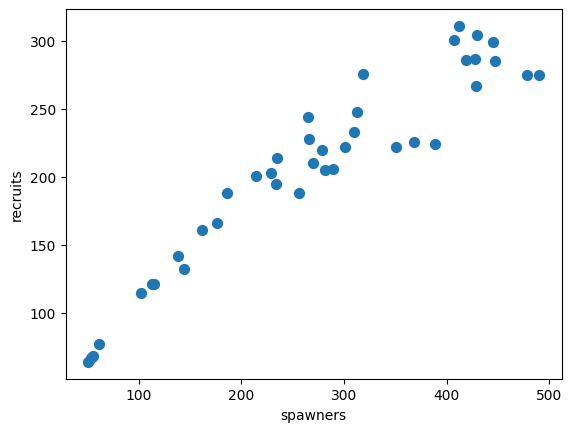

In [ ]:
import requests
import pandas as pd
import io

target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/salmon.txt'
download = requests.get(target_url).content

salmon_data = pd.read_table(io.StringIO(download.decode('utf-8')), sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);


In [ ]:
#we have prior knowledge about fish population growth, and we can include a linear mean function as a prior

with pm.Model() as salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 1)
    η = pm.HalfCauchy('η', 1)
    #η=1

    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ)

In [ ]:
with salmon_model:

    σ = pm.HalfCauchy('σ', 1)

    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1),
                           y=salmon_data.recruits.values, noise=σ)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
with salmon_model:
    salmon_trace = pm.sample(1000, return_inferencedata=True)

array([[<Axes: title={'center': 'ρ'}>, <Axes: title={'center': 'ρ'}>],
       [<Axes: title={'center': 'η'}>, <Axes: title={'center': 'η'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

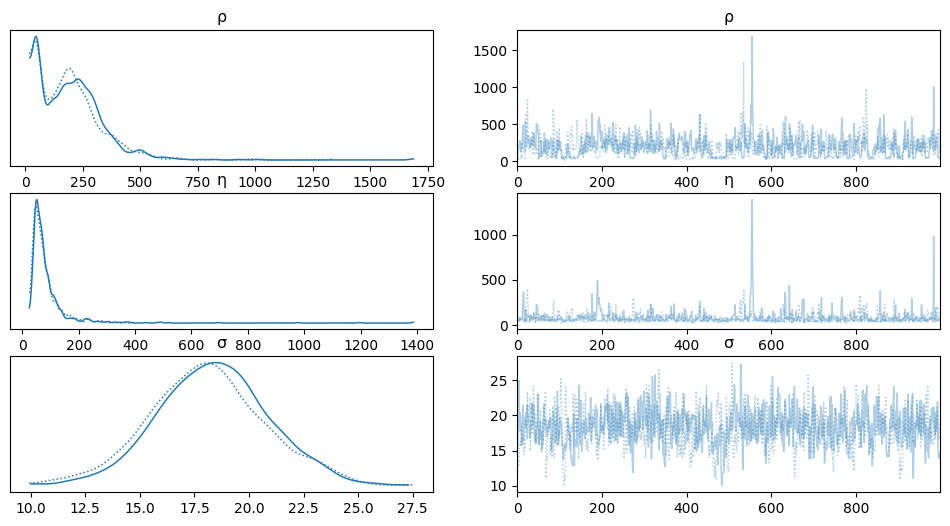

In [ ]:
az.plot_trace(salmon_trace, var_names=['ρ','η','σ']) #'η'


In [ ]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)

with salmon_model:
    salmon_pred3 = recruit_gp.conditional('salmon_pred3', X_pred)


In [ ]:
with salmon_model:
    salmon_samples = pm.sample_posterior_predictive(salmon_trace, var_names=['salmon_pred3'])

In [ ]:
salmon_data['spawners'].values

array([ 56,  62, 445, 279, 138, 428, 319, 102,  51, 289, 351, 282, 310,
       266, 256, 144, 447, 186, 389, 113, 412, 176, 313, 162, 368,  54,
       214, 429, 115, 407, 265, 301, 234, 229, 270, 478, 419, 490, 430,
       235])

(-100.0, 400.0)

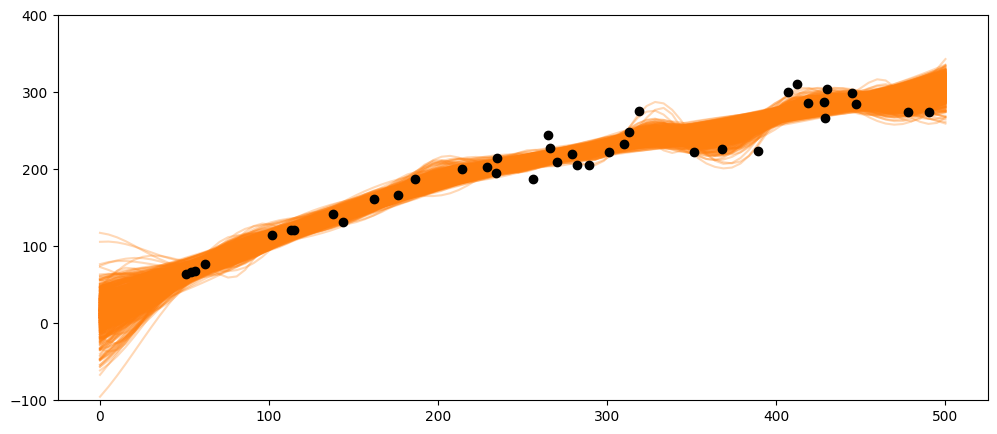

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_pred, salmon_samples.posterior_predictive['salmon_pred3'].mean(axis=0).T, 'C1-', alpha=0.3)
ax.plot(salmon_data['spawners'].values,salmon_data['recruits'].values, 'ko')
#ax.set_xlabel('X')
ax.set_ylim(-100,400)

What happens if the population gets very large, e.g., at 600 or 800 spawners?

In [ ]:
X_pred = np.linspace(0, 800, 100).reshape(-1, 1)

with salmon_model:
    salmon_pred4 = recruit_gp.conditional('salmon_pred4', X_pred)

In [ ]:
with salmon_model:
    salmon_samples = pm.sample_posterior_predictive(salmon_trace, var_names=['salmon_pred4'])

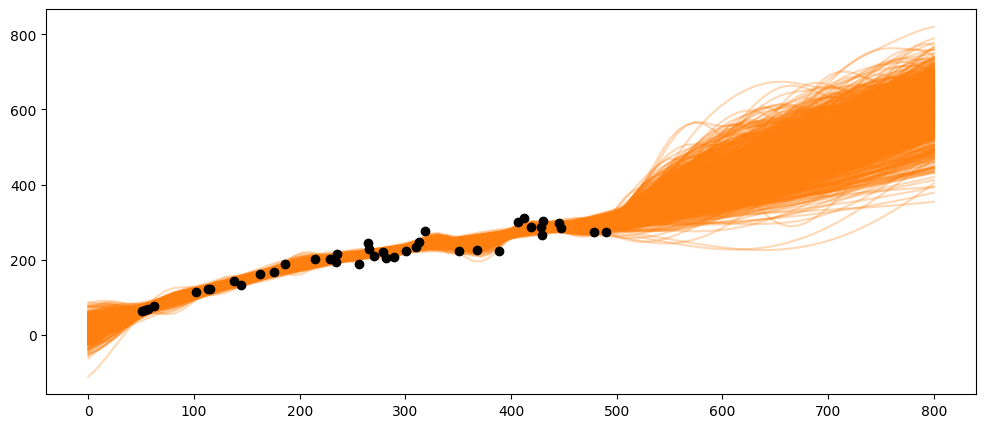

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_pred, salmon_samples.posterior_predictive['salmon_pred4'].mean(axis=0).T, 'C1-', alpha=0.3)
ax.plot(salmon_data['spawners'].values,salmon_data['recruits'].values, 'ko')

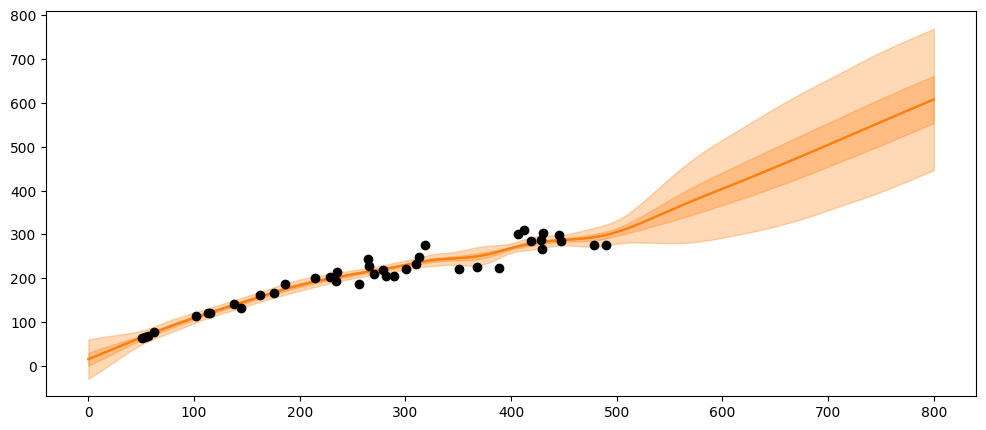

In [ ]:
_, ax = plt.subplots(figsize=(12,5))

mu = salmon_samples.posterior_predictive['salmon_pred4'].mean(axis=0).T.mean(axis=1)
sd = salmon_samples.posterior_predictive['salmon_pred4'].std(axis=0).T.mean(axis=1)


ax.plot(X_pred,mu,'C1')
ax.fill_between(X_pred.flatten(),mu-sd,mu+sd, color="C1",alpha=0.3)

ax.plot(X_pred,mu,'C1')
ax.fill_between(X_pred.flatten(),mu-3*sd,mu+3*sd, color="C1",alpha=0.3)


ax.plot(salmon_data['spawners'].values,salmon_data['recruits'].values, 'ko')
